<a href="https://colab.research.google.com/github/yakaboskic/ENGS_108_Fall_2020/blob/master/assign_6_ENGS_108_Fall_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ENGS 108 Fall 2021 Assignment 6**

*Due October 23 2021

**Instructors:** George Cybenko

**TAs:** Clement Nyanhongo, Jack Sadoff


---

## **Rules and Requirements**


1.   You are only allowed to use Python packages that are explicity imported in 
the assignment notebook or are standard (bultin) python libraries like random, os, sys, etc, (Standard Bultin Python libraries will have a Python.org documentation). For this assignment you may use:
  *   [numpy](https://numpy.org/doc/stable/)
  *   [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html)
  *   [scikit-learn](https://scikit-learn.org/stable/)
  *   [matplotlib](https://matplotlib.org/)
  *   [tensorflow](https://www.tensorflow.org/)

2.   All code must be fit into the designated code or text blocks in the assignment notebook. They are indentified by a **TODO** qualifier.

3. For analytical questions that don't require code, type your answer cleanly in Markdown. For help, see the [Google Colab Markdown Guide](https://colab.research.google.com/notebooks/markdown_guide.ipynb).

---

In [1]:
''' Import Statements '''
from collections import defaultdict
import copy
import itertools

import random
# Don't mess with this (gives reproducible results)
random.seed(444)

## **Problem 1: Reinforcement Learning**
In this problem we will play a game of cops and robbers. The game is played on a fixed undirected, simple, and finite graph $G$. There are two players, a cop and a robber. It is the goal of the cop to catch the robber in as few moves as possible. 

The graph $G$ has the following properties:
  - A total of $m$ nodes.
  - It contains a single $n$ node cycle, where $n\leq m$, and random additional edges to make the graph connected.

The game starts, with the cop taking their choice of vertex in $G$ and then the robber selects a random vertex in $G$ that is not occupied by the cop. At every point in the game both players know the positions of each other, and in this version of the problem we will say that the robber is drunk (i.e. they will randomly choose there next that instead of employing a policy).

The availabe actions of the cop and associated reward function is:
  - Move to a node not connected to their present node (and the cop stays in the current position): -5.
  - Move to an adjacent node (including staying at current node): -1.
  - Move to the node occupied by robber: +100.
>
> **Part 1** Building a Graph Class.
>> **(a)** Using the provided skeleton build a general graph class for this problem for $n$ nodes. You are expected to implement *add_edge*, *make_random_graph*, *check_connected*.

In [2]:
import collections
import copy
import random
import collections
import networkx as nx 
import matplotlib.pyplot as plt

class Graph:
  """ Our graph class.
  Args:
    n: Number of nodes in our cycle.
    m: Total number of nodes in graph, where n >= m.
  """
  def __init__(self, n, m):
        
    if (n > m):
        raise Exception("n <= m must be true")
    self.n = n
    self.m = m
    
    # A default dict is just a dict that won't raise a KeyError, it instead fills
    # the unknown key with a default, in our case an empty list.
    self.G = collections.defaultdict(list)

  def add_edge(self, u, v):
    """
    Make a function that will add an edge to the graph.
    """
    if (u>self.m-1 or v>self.m-1):
        raise Exception("node ids for new edge must both be less than " + str(self.m))

    self.G[u].append(v)


  def make_random_graph(self):
    """ First make a cycle of given length and then add random additional edges
    in such a way that the final graph will be connected.
    """
    #TODO: Make n length cycle first
    count=0
    #make a chain of the first n elements
    for i in range(self.n-1):
        self.G[i].append(i+1)
    #connect head and tail of chain
    self.G[self.n].append(0)
    
    
    #TODO: Add additional nodes until random graph is connected
    while True:
      _graph = copy.copy(self)
      uNew = random.randint(0,self.m-1)
      vNew = random.randint(0,self.m-1)
      _graph.G[uNew].append(vNew) if vNew not in _graph.G[uNew] else _graph.G[uNew]

      if self.check_connected(_graph):
        # If it is set the current graph's adjacency matrix equal to the copy's.
        self.graph = _graph.G
        # Return (i.e. break the loop)
        return True

  def check_connected(self, G):
    """ Perform a Depth First Search.
    """
    start_node = random.choice(list(G.G.keys()))
    return dfs(G, [], start_node)

#note that "parent" param is not strictly necessary
#as long as we check whether a child node is already
#in the listed of visited nodes before calling the 
#recursive function on it

def dfs(G, visited, u):
    """ Implement your own depth first search. Many online resources for this.
    Args:
    G: Is the graph (adjency matrix) we want to test.
    visited: Is a dictionary that keeps track of the nodes you've visited.
    u: a starting node.
    Returns:
    True: If all nodes have been visited at least once.
    False: Otherwise.
    """
    adjacent_nodes = G.G[u]
    for node in adjacent_nodes:
        if node not in visited:
            visited.append(node)
            dfs(G,visited,node)
    if len(visited)==G.m:
        return(True)
    else: return(False)



>> **(b)** Test out your graph class with a cops and robbers graph of $n=5$ and $m=10$.

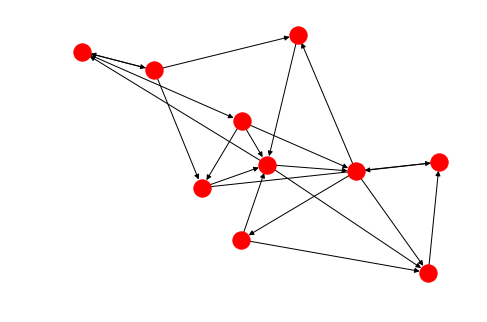

In [114]:
g = Graph(5,10)
g.make_random_graph()

plotGraph = nx.DiGraph() 

for i in range(g.m): 
 for j in range( g.m): 
   if j in g.G[i]: 
      plotGraph.add_edge(i,j) 
nx.draw( plotGraph) 
plt.show() 

> **Part 2** Understanding the state space, i.e. the Game.
>> **(a)** Given the graph class you've created in Part 1. Develop a Cops and Robbers game class. Use the skeleton below to implement the following functions first: *get_successors*, *terminal_test*, *result*. 


In [115]:
class CopsAndRobbers:
  def __init__(self, graph, start_state, rewards_table=None):
    """ This is the cops and robbers game class.
    Args:
      start_state: The starting state of the cop position and robber position in
        the graph. Should be a tuple of form (cop_pos, rob_pos).
      G: The graph adjacency matrix
      state: current state in the game.
      reward_table: The (state, actions) reward dictionary that you will eventually implement.
    """
    self.graph = graph
    self.G = graph.G
    self.state = start_state
    self.rewards_table = rewards_table

  def terminal_test(self, state):
    """test for terminal condition"""
    if (state[0]==state[1]): 
        print("state[0]: " + str(state[0]) + ", state[1]: " + str(state[1]))
        return(True)
    else: return(False)
    
  def get_successors(self, state):
    """ Return a list of successor states that can be reached from the current state.
    Hint: Remember only the cop can choose their action.
    """
    copNextStates = self.G[state[0]]
    #cop should be able to stay still
    copNextStates.append(state[0]) if state[0] not in copNextStates else copNextStates
    
    successorStates = []
    for i in copNextStates:
        successorStates.append((i,state[1]))
    return(successorStates)

  def get_successors_robber(self, state):
    """ Return a list of successor states that can be reached from the current state after the robber moves.
    """
    robNextStates = self.G[state[1]]
    #cop should be able to stay still
    robNextStates.append(state[1]) if state[1] not in robNextStates else robNextStates
    
    successorStates = []
    for i in robNextStates:
        successorStates.append((state[0],i))
    return(successorStates)

  def result(self, next_state):
    """ This function should return the state after the cop has made their move,
    and the drunk robber has moved accordingly.
    Args:
      state: Current state of (cop, rob).
      next_state: The state after the cop has moved (next_cop, rob). Calculated from get_successors.
    """
    
    successorStates = self.get_successors_robber(next_state)
    final_state = random.choice(successorStates)
    self.state = final_state
    return(final_state)

    
  def utility(self, state, action):
    return self.rewards_table[(state, action)]

CR = CopsAndRobbers(g,(0,1))
CR.get_successors(CR.state)
CR.terminal_test((1,1))

state[0]: 1, state[1]: 1


True

>> **(b)** In reinforcement learning we are often interested in calculating a rewards table that has possible states as its rows and possible actions as its columns and filled in with the associated reward given the Q(state, action) pair. Calculate the rewards table for any given graph. *Hint: This should be an $m^2$ x $m$ matrix or a dictionary with $m^3$ keys such that the keys are (state, action) tuples.*  

In [166]:
def calculateRewardsTable(graph):
  """ Make a rewards table dictionary of the from table[(state, action)] = reward. recall:
  The availabe actions of the cop and associated reward function is:

  Move to a node not connected to their present node (and the cop stays in the current position): -5.
  Move to an adjacent node (including staying at current node): -1.
  Move to the node occupied by robber: +100.
  """
  table = collections.defaultdict(list)
  for c_state_ind in range(graph.m):
    for r_state_ind in range(graph.m):
        for action in range(graph.m):
            reward = 0
            cop_robber = (c_state_ind,r_state_ind)
            if (action==r_state_ind):
                reward=100
            elif action in graph.G[c_state_ind]:
                reward=-1
            else:
                reward = -5
            table[(cop_robber,action)]=reward
  return table



>> **(c)** Now that we have our reward table, try to solve the problem in a brute-force manner (without reinforcement learning). I.e. try to reach the terminal state, or find get a reward of 100. 

In [169]:

print(str(g.G))
rTable = calculateRewardsTable(g)
cr = CopsAndRobbers(g,(2,3),rTable)
def simulate_random(cr):
# Simulation loop
    epochs=0
    rewards = []
    penalties = 0
    while True:
      epochs=epochs+1
      print("epoch #" + str(epochs))
      previousState = cr.state
      #print('previousState: ' + str(previousState))
      cSuccessors = cr.get_successors(previousState)
      #get successor states where robber is the same as current (robber hasn't moved yet)
      attemptedNextCopState = random.choice(range(cr.graph.m))
      reward=rTable[(previousState,attemptedNextCopState)]
      
      nextStateWithoutRobberMoving = (attemptedNextCopState,previousState[1])
      #if cop moved to non-adjacent node, reset their position
      if reward==-5:
        print("attempted to move cop from " + str(previousState[0]) + " to non-adjacent node " + str(attemptedNextCopState))
        nextStateWithoutRobberMoving = previousState
      else:
        print("moving cop from " + str(previousState[0]) + " to adjacent node " + str(attemptedNextCopState))

      
      nextState = cr.result(nextStateWithoutRobberMoving)
      rewards.append(reward)
      print("next state: " + str(nextState))
      if (reward ==100):
            print("found robber!")
      if (cr.terminal_test(nextState)):
        break
    return(rewards,epochs)

rewards,term = simulate_random(cr)
print("rewards: " + str(rewards) + ", # epochs to terminate: " + str(term))

defaultdict(<type 'list'>, {0: [1, 4, 0], 1: [2, 3, 6, 1], 2: [3, 2, 8, 7], 3: [4, 3], 4: [2, 4], 5: [0, 1, 2, 5], 6: [5, 9, 6], 7: [1, 3, 7], 8: [8, 1], 9: [9, 8, 6, 0], 10: [10], 11: [11], 12: [12], 13: [13], 14: [14], 15: [15], 17: [17], 18: [18], 19: [19], 23: [23], 28: [28], 29: [29], 31: [31], 34: [34], 35: [35], 36: [36], 37: [37], 38: [38]})
epoch #1
attempted to move cop from 2 to non-adjacent node 6
next state: (2, 4)
epoch #2
attempted to move cop from 2 to non-adjacent node 0
next state: (2, 4)
epoch #3
attempted to move cop from 2 to non-adjacent node 5
next state: (2, 4)
epoch #4
attempted to move cop from 2 to non-adjacent node 0
next state: (2, 2)
state[0]: 2, state[1]: 2
rewards: [-5, -5, -5, -5], # epochs to terminate: 4


> **Part 3** Q-learning. 
>
> Up to this point we have build a graph class, built a game class, ran a brute-force simulation of an agent traversing the space randomly, and now we will dive into Q-learning in the hopes of maximizing the rewards and efficiency of capturing the drunk robber. 
>
>> **(a)** Using the skeleton from the brute force method, implement a training loop to learn a Q-table for a given graph and game. 

In [147]:
class QTable:
    def __init__(self,graph,alpha=.1,gamma=.1):
        self.n_states = graph.m
        self.RTable = calculateRewardsTable(graph)
        #initialize q table
        table = collections.defaultdict(list)
        for c_state_ind in range(graph.m):
            for r_state_ind in range(graph.m):
                for action in range(graph.m):
                    cop_robber = (c_state_ind,r_state_ind)
                    table[(cop_robber,action)]=0
        self.QTable = table
        self.alpha = alpha
        self.gamma = gamma
        
    def updateQTable(self,state,action):
        oldQVal = self.QTable[state,action]
        reward = self.RTable[state,action]
        bestAction = None
        highestQ = -1000000
        nextStateCop = (action,state[1])
        if (reward==-5):
            print("can't go there!")
            nextStateCop = state
        nextStateBoth = cr.result(nextStateCop)
        for thisAction in range(self.n_states):
            thisQ = self.QTable[nextStateBoth,thisAction]
            if thisQ>highestQ:
                highestQ = thisQ
                bestAction = thisAction
        print("self.alpha: "+str(self.alpha)+ ", oldQVal: " + str(oldQVal) + ", reward: " + str(reward) + ", self.gamma: " + str(self.gamma) + ", highestQ: " + str(highestQ))
        newQVal = (1-self.alpha)*oldQVal+self.alpha*(reward+self.gamma*highestQ)
        print("setting new q value for state "+str(state)+" and action " + str(action) +": " + str(newQVal))
        self.QTable[state,action]=newQVal
        return(newQVal)

      
    


>> **(b)** Evalute your new Q-learning agent over a 100 epochs, by choosing your actions based on the argmax of the Q-table caluculated in (a) and report the average number of penalities, average time, and average number of steps it took to find the robber with your new Q-learning strategy. 

In [150]:
g2 = Graph(5,10)
g2.make_random_graph()
print(str(g2.G))

defaultdict(<type 'list'>, {0: [1, 0], 1: [2, 8], 2: [3, 1, 5, 9], 3: [4, 0], 4: [0, 1], 5: [0, 9], 6: [6, 0], 7: [7], 8: [8, 7, 6], 9: []})


In [151]:
rTable2 = calculateRewardsTable(g2)
cr2 = CopsAndRobbers(g2,(0,1),rTable2)
def QLearningSim(cr_temp):
    epochs = 0
    rewards = []
    penalties = 0
    qTable= QTable(cr_temp.graph,alpha=.5,gamma=.5)
    # Simulation loop
    while True:
      epochs=epochs+1
      print("epoch #" + str(epochs))
      previousState = cr_temp.state
      print("previous state: " + str(previousState))
      bestQVal = -10000
      bestAction = None
      for i in range(cr_temp.graph.m):
            qVal = qTable.QTable[previousState,i]
            if qVal>bestQVal:
                bestQVal = qVal
                bestAction = i

      print("best action: " + str(bestAction))
      #calculate reward based on previous state of cops, next state of robber, and action (new state of cop)
      nextStateWithoutRobberMoving = (bestAction, previousState[1]) #this is for a random cop
      #print("nextStateWithoutRobberMoving: " + str(nextStateWithoutRobberMoving))
      nextState = cr_temp.result(nextStateWithoutRobberMoving)
      qTable.updateQTable(previousState,bestAction)
      nextStateWithoutCopMoving = (previousState[0],nextState[1])
      #calculate reward based on previous state of cops and robbers and new state of cop
      print("nextStateWithoutCopMoving: " + str(nextStateWithoutCopMoving) + ", nextState[0]: " + str(nextState[0]))
      reward=rTable2[(nextStateWithoutCopMoving,nextState[0])]
      rewards.append(reward)
      if (cr_temp.terminal_test(nextState)):
        break
    return(rewards,epochs)
rewards, term = QLearningSim(cr2)
print("rewards: " + str(rewards) + ", epochs to terminate: " + str(term))

epoch #1
previous state: (0, 1)
best action: 0
self.alpha: 0.5, oldQVal: 0, reward: -1, self.gamma: 0.5, highestQ: 0
setting new q value for state (0, 1) and action 0: -0.5
nextStateWithoutCopMoving: (0, 8), nextState[0]: 0
epoch #2
previous state: (0, 8)
best action: 0
self.alpha: 0.5, oldQVal: 0, reward: -1, self.gamma: 0.5, highestQ: 0
setting new q value for state (0, 8) and action 0: -0.5
nextStateWithoutCopMoving: (0, 7), nextState[0]: 0
epoch #3
previous state: (0, 7)
best action: 0
self.alpha: 0.5, oldQVal: 0, reward: -1, self.gamma: 0.5, highestQ: 0
setting new q value for state (0, 7) and action 0: -0.5
nextStateWithoutCopMoving: (0, 7), nextState[0]: 0
epoch #4
previous state: (0, 7)
best action: 1
self.alpha: 0.5, oldQVal: 0, reward: -1, self.gamma: 0.5, highestQ: 0
setting new q value for state (0, 7) and action 1: -0.5
nextStateWithoutCopMoving: (0, 7), nextState[0]: 1
epoch #5
previous state: (1, 7)
best action: 0
self.alpha: 0.5, oldQVal: 0, reward: -5, self.gamma: 0.5,

>> **(c)** Compare your results with the brute-force method used in Part 2 and comment on the improvement. For instance, try varying graph configurations and look for any signs of improvement in certian instances. 

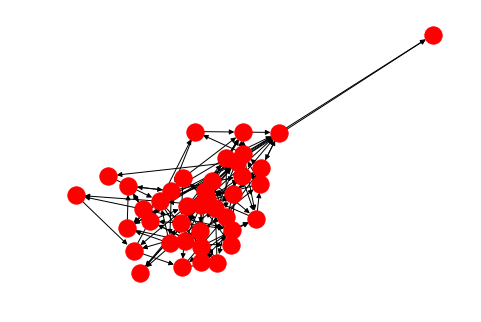

NameError: name 'simulate_random' is not defined

In [67]:
simulate_random(cr2)

> **Bonus** Check that the learned policy satsifies the [Bellman Inequality](https://towardsdatascience.com/mathematical-analysis-of-reinforcement-learning-bellman-equation-ac9f0954e19f), i.e is the computed solution the actual optimal policy?

In [ ]:
#TODO: Your code goes here.